In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Load modified dataset obtained after EDA

In [27]:
df = pd.read_csv('Cleaned_Telco-Customer-Churn.csv')
df.head()

,Senior Citizen,Partner,Dependents,Tenure Months,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,CLTV
0,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,10.399519,1,3239
1,No,No,Yes,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,12.314625,1,2701
2,No,No,Yes,8,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,28.644371,1,5372
3,No,Yes,Yes,28,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,55.191032,1,5003
4,No,No,Yes,49,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,70.966894,1,5340


One Hot Encoding

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#Duplicate dataframe
df1 = df.copy()

#Split  the data into categorical and numerical feaures
cat_col = df1.select_dtypes(include='object')
num_col = df1.select_dtypes(include=['int64','float64'])
    

#One hot encoding categorical features 
encoder = OneHotEncoder(drop='first',sparse_output=False)
cat_encoded = encoder.fit_transform(cat_col)
cat_encoded = pd.DataFrame(cat_encoded,columns=encoder.get_feature_names_out(cat_col.columns))

#Combine categorical and numerical features into one df
df_encoded = pd.concat([cat_encoded,num_col],axis=1)
df_encoded.head()


,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Tenure Months,Monthly Charges,Total Charges,Churn Value,CLTV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2,53.85,10.399519,1,3239
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2,70.70,12.314625,1,2701
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,8,99.65,28.644371,1,5372
3,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,28,104.80,55.191032,1,5003
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,49,103.70,70.966894,1,5340


Data Standardization

In [30]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

In [31]:
df_encoded[['Tenure Months','Monthly Charges','Total Charges','CLTV']] = scaler.fit_transform(df_encoded[['Tenure Months','Monthly Charges','Total Charges','CLTV']])
df_encoded.head()

,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Tenure Months,Monthly Charges,Total Charges,Churn Value,CLTV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.236724,-0.362660,-1.248349,1,-0.981675
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.236724,0.197365,-1.170252,1,-1.436462
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.992402,1.159546,-0.504334,1,0.821409
3,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.177995,1.330711,0.578223,1,0.509483
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.677133,1.294151,1.221553,1,0.794358


Data Splitting into train and test dataset

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
x = df_encoded.drop(['Churn Value'],axis=1)
y = df_encoded['Churn Value']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=4567)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 29)
(1409, 29)
(5634,)
(1409,)


Churn Prediction using different Classification models

Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Define decison tree classifier 
model_tree = DecisionTreeClassifier(random_state=467)
model_tree.fit(x_train,y_train)
y_pred = model_tree.predict(x_test)
print(model_tree.score(x_test,y_test))
print(model_tree.score(x_train,y_train))

0.7175301632363378
1.0


In [ ]:
#Evaluate decision tree classifier for better understanding of performance
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

Accuracy: 0.718
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1025
           1       0.48      0.48      0.48       384

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409



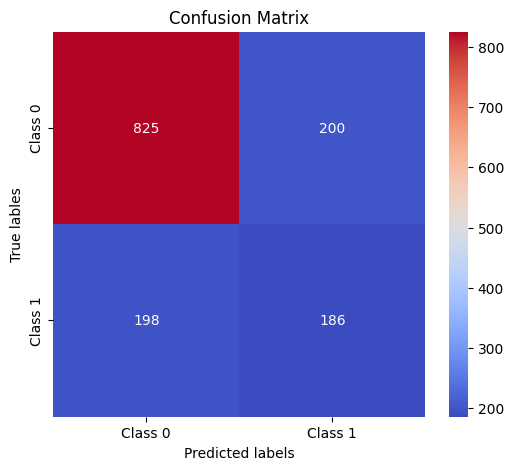

In [37]:
print('Accuracy:',round(accuracy_score(y_test,y_pred),3))
print('Classification Report:\n',classification_report(y_test,y_pred)) 
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,cmap='coolwarm',fmt='d',xticklabels=['Class 0','Class 1'],yticklabels=['Class 0','Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True lables')
plt.title('Confusion Matrix')
plt.show()

The decision tree model is overfitting the training data having accuracy of 1 for class 0 i.e. [chrun value = No] because the class is imbalanced and that's why it is required to resample for better results

Resample the imbalanced data 

In [38]:
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=1568)

In [ ]:
#Resample the x and y coordinates
x_resampled,y_resampled = smoteenn.fit_resample(x,y)

#Split the resampled data
rex_train,rex_test,rey_train,rey_test = train_test_split(x_resampled,y_resampled,test_size=0.2,random_state=4579)
print('y_train(1):',sum(y_train==1))
print('y_train(0):',sum(y_train==0))
print('re_y_train(1)',sum(rey_train==1))
print('re_y_train(0)',sum(rey_train==0))

y_train(1): 1485
y_train(0): 4149
re_y_train(1) 3177
re_y_train(0) 2308


Optimization of decision tree hyperparameters 

In [40]:
from sklearn.model_selection import GridSearchCV
estimator = DecisionTreeClassifier()
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,6,8],'min_samples_split':[2,4,6],'min_samples_leaf':[1,2,3]}
grid_search = GridSearchCV(estimator, param_grid=param_grid, verbose=2)
grid_search.fit(x,y)
print(grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1

In [ ]:
#Re-run the tree classifier
re_model_tree= DecisionTreeClassifier(max_depth=6,min_samples_split=2,min_samples_leaf=3,criterion='gini',random_state=237)
re_model_tree.fit(rex_train,rey_train)
y_pred = re_model_tree.predict(rex_test)
print(re_model_tree.score(rex_test,rey_test))
print(re_model_tree.score(rex_train,rey_train))

0.9256559766763849
0.9296262534184139


Accuracy: 0.926
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       589
           1       0.91      0.96      0.94       783

    accuracy                           0.93      1372
   macro avg       0.93      0.92      0.92      1372
weighted avg       0.93      0.93      0.93      1372



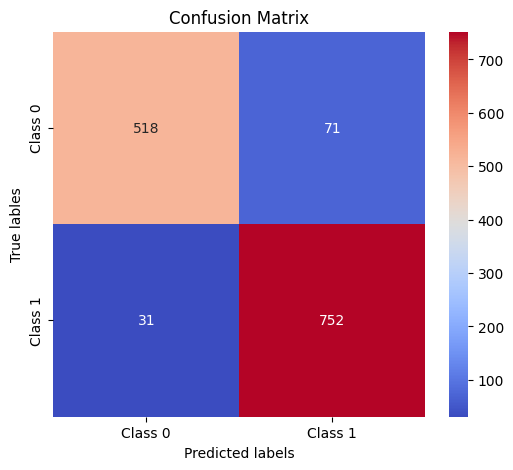

In [ ]:
#Re-evaluate the decision tree classifier 
print('Accuracy:',round(accuracy_score(rey_test,y_pred),3))
print('Classification Report:\n',classification_report(rey_test,y_pred)) 
cm = confusion_matrix(rey_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,cmap='coolwarm',fmt='d',xticklabels=['Class 0','Class 1'],yticklabels=['Class 0','Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True lables')
plt.title('Confusion Matrix')
plt.show()

Now the decision tree classifier has improved it's performance from 72% to 93% with f1 score of 91% and 94% for class 0 and class 1 by resampling the data and optimizing the hyperparameters for the classifier

Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Define the random forest classifier
model_forest = RandomForestClassifier(n_estimators=100,max_depth=6,min_samples_split=5,min_samples_leaf=3,criterion='entropy',random_state=347)
model_forest.fit(rex_train,rey_train)
y_pred = model_forest.predict(rex_test)
print(model_forest.score(rex_test,rey_test))
print(model_forest.score(rex_train,rey_train))

0.9285714285714286
0.9309024612579763


Refine the hyperparameters for random forest 

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator = RandomForestClassifier()
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,6,8],'min_samples_split':[2,4,6],'min_samples_leaf':[1,2,3]}
grid_search = GridSearchCV(estimator, param_grid=param_grid, verbose=2)
grid_search.fit(x,y)
print(grid_search.best_params_)


KeyboardInterrupt



In [ ]:
#Re-define the forest classifier after the hyperparameter tuning
re_model_forest = RandomForestClassifier(n_estimators=100,max_depth=8,min_samples_split=6,min_samples_leaf=3,criterion='entropy',random_state=347)
re_model_forest.fit(rex_train,rey_train)
y_pred = re_model_forest.predict(rex_test)
print(re_model_forest.score(rex_test,rey_test))
print(re_model_forest.score(rex_train,rey_train))

0.9482507288629738
0.9571558796718322


Accuracy: 0.948
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       589
           1       0.94      0.97      0.96       783

    accuracy                           0.95      1372
   macro avg       0.95      0.94      0.95      1372
weighted avg       0.95      0.95      0.95      1372



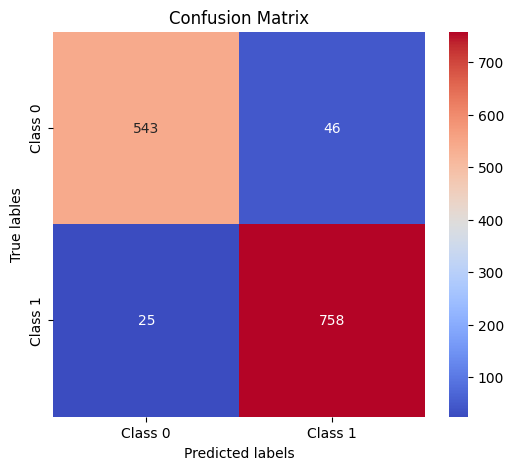

In [ ]:
#Re-evaluate the refined random forest classifier 
print('Accuracy:',round(accuracy_score(rey_test,y_pred),3))
print('Classification Report:\n',classification_report(rey_test,y_pred)) 
cm = confusion_matrix(rey_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,cmap='coolwarm',fmt='d',xticklabels=['Class 0','Class 1'],yticklabels=['Class 0','Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True lables')
plt.title('Confusion Matrix')
plt.show()

Random forest classifier is performing well in terms of accuracy, f1 score, recall and precision  with reduction of overfitting in training dataset unlike decision tree classifier

Evaluate Random forest by ROC-AUC score

In [48]:
from sklearn.metrics import roc_curve,roc_auc_score

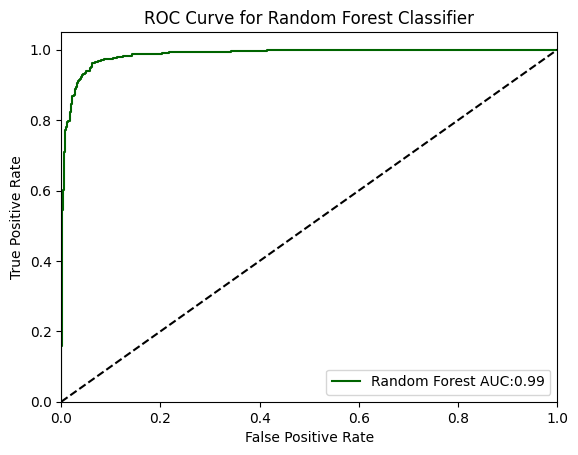

In [49]:
y_proba = re_model_forest.predict_proba(rex_test)[:,1]
fpr,tpr,thresholds = roc_curve(rey_test,y_proba)
auc_score = roc_auc_score(rey_test,y_proba)

#Visualizing ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', label=f'Random Forest AUC:{round(auc_score,2)}')
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

With 99% AUC score, random forest classifier is doing great at identifying churned and non churned classes

Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Define logistic regression model
regression_model = LogisticRegression(solver='liblinear',C=0.5,penalty='l2',random_state=348)
regression_model.fit(rex_train,rey_train)
y_pred = regression_model.predict(rex_test)
print(regression_model.score(rex_test,rey_test))
print(regression_model.score(rex_train,rey_train))

0.9074344023323615
0.9103008204193255


Accuracy: 0.907
classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       589
           1       0.92      0.92      0.92       783

    accuracy                           0.91      1372
   macro avg       0.91      0.90      0.91      1372
weighted avg       0.91      0.91      0.91      1372



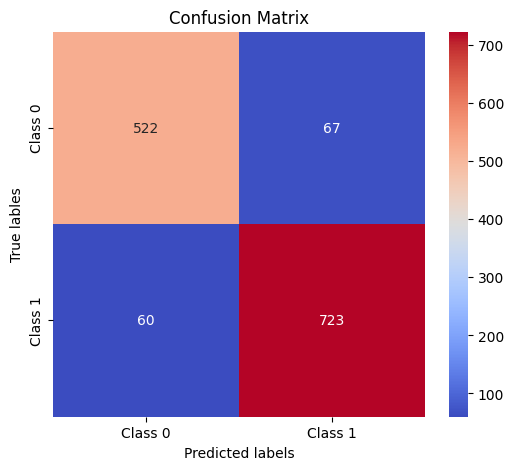

In [ ]:
#Evaluate the regression model
print('Accuracy:',round(accuracy_score(rey_test,y_pred),3))
print('classification Report:\n',classification_report(rey_test,y_pred))
cm = confusion_matrix(rey_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,cmap='coolwarm',fmt='d',xticklabels=['Class 0','Class 1'],yticklabels=['Class 0','Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True lables')
plt.title('Confusion Matrix')
plt.show()

Optimize Hyperparameters for Logistic Regression

In [53]:
estimator = LogisticRegression()
param_grid ={'C':[0.1,0.5,1],'penalty':['l1','l2']}
grid_search = GridSearchCV(estimator,param_grid,verbose=2)
grid_search.fit(x,y)
print(grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.5, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.5,

In [ ]:
#Re-run the regression model
re_regression_model = LogisticRegression(solver='liblinear',C=1,penalty='l2',random_state=348)
re_regression_model.fit(rex_train,rey_train)
y_pred = re_regression_model.predict(rex_test)
print(re_regression_model.score(rex_test,rey_test))
print(re_regression_model.score(rex_train,rey_train))

0.9059766763848397
0.9101185050136736


Accuracy: 0.906
classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       589
           1       0.91      0.92      0.92       783

    accuracy                           0.91      1372
   macro avg       0.90      0.90      0.90      1372
weighted avg       0.91      0.91      0.91      1372



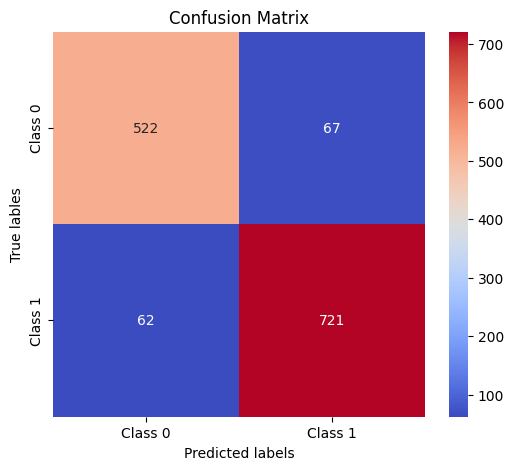

In [ ]:
#Re-evaluate the regression model
print('Accuracy:',round(accuracy_score(rey_test,y_pred),3))
print('classification Report:\n',classification_report(rey_test,y_pred))
cm = confusion_matrix(rey_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,cmap='coolwarm',fmt='d',xticklabels=['Class 0','Class 1'],yticklabels=['Class 0','Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True lables')
plt.title('Confusion Matrix')
plt.show()

As observed, logistic regression model is showing poor perfromance making it inadequate in presence of random forest classifier.

SVM Model

In [ ]:
#Define support vector machine classifier
from sklearn import svm
svc = svm.SVC(random_state=784)
svc.fit(rex_train,rey_train)
y_pred = svc.predict(rex_test)

Accuracy: 0.944
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       589
           1       0.94      0.96      0.95       783

    accuracy                           0.94      1372
   macro avg       0.94      0.94      0.94      1372
weighted avg       0.94      0.94      0.94      1372



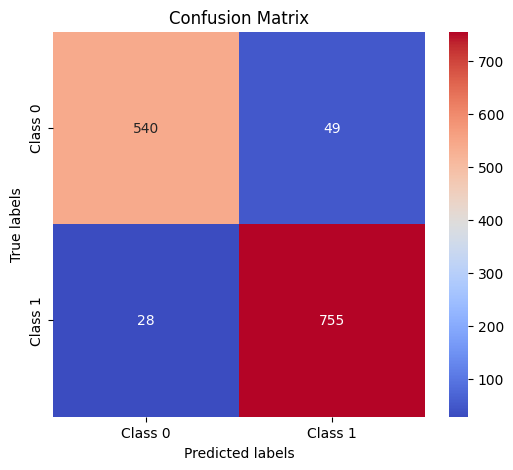

In [ ]:
#Evaluate SVM classifier 
print('Accuracy:',round(accuracy_score(rey_test,y_pred),3))
print('Classification Report:\n',classification_report(rey_test,y_pred))
cm = confusion_matrix(rey_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap='coolwarm', fmt='d',annot=True, xticklabels=['Class 0','Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Hyperparameters tunning for SVM classifier

In [58]:
estimator = svm.SVC()
param_grid ={'C':[0.1,0.5,1],'gamma':[0.01,0.1,0.5], 'kernel':['rbf']}
grid_search = GridSearchCV(estimator,param_grid,verbose=2)
grid_search.fit(x,y)
print(grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.9s
[CV] END .......................C=0.1, gamma=0.5, kernel=rbf; total time=   2.7s
[CV] END .......................C=0.1, gamma=0.5,

In [ ]:
#Re-run the SVM classifier
svc_model = svm.SVC(C=1,gamma=0.01,kernel='rbf',random_state=784) 
svc_model.fit(rex_train,rey_train)
y_pred = svc_model.predict(rex_test)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       589
           1       0.92      0.92      0.92       783

    accuracy                           0.91      1372
   macro avg       0.91      0.91      0.91      1372
weighted avg       0.91      0.91      0.91      1372



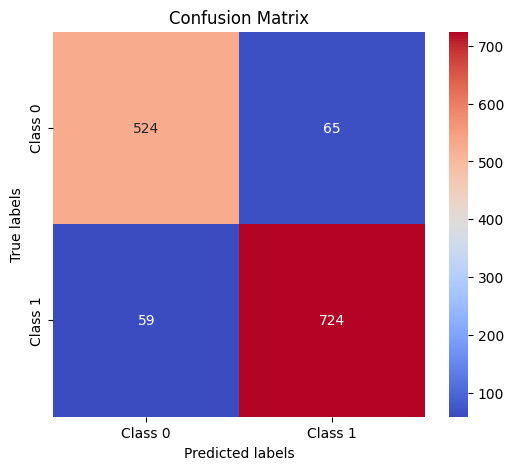

In [ ]:
#Evaluate SVM classifier again
print('Accuracy:',round(accuracy_score(rey_test,y_pred),3))
print('Classification Report:\n',classification_report(rey_test,y_pred))
cm = confusion_matrix(rey_test,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap='coolwarm', fmt='d',annot=True, xticklabels=['Class 0','Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

After refinement of SVM classifier, model's performance is decreased clarifying that Random forest classifier has outperform predicting churned and non churned class with 95% accuracy and 99% AUC score.

Saving the model and scaler function

In [61]:
import pickle

In [ ]:
#Save the scaler function to a pickle file
scalerfile = 'churn_scaler.pkl'
pickle.dump(scaler,open(scalerfile,'wb'))

In [ ]:
#Save the model to a pickle file
filename = 'churn_model.pkl'
pickle.dump(re_model_forest,open(filename,'wb'))